In [13]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

import matplotlib.pyplot as plt
import seaborn as sns

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import warnings
warnings.filterwarnings('ignore')

In [14]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))

sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

# Load Data

In [15]:
df_all = pd.read_pickle("data/merged data7.pkl.zip")

In [16]:
df_factor = df_all[df_all.columns[3:-1]]

# Correlation Analysis

## Factor Correlation

In [17]:
corr_all = df_factor.corr()

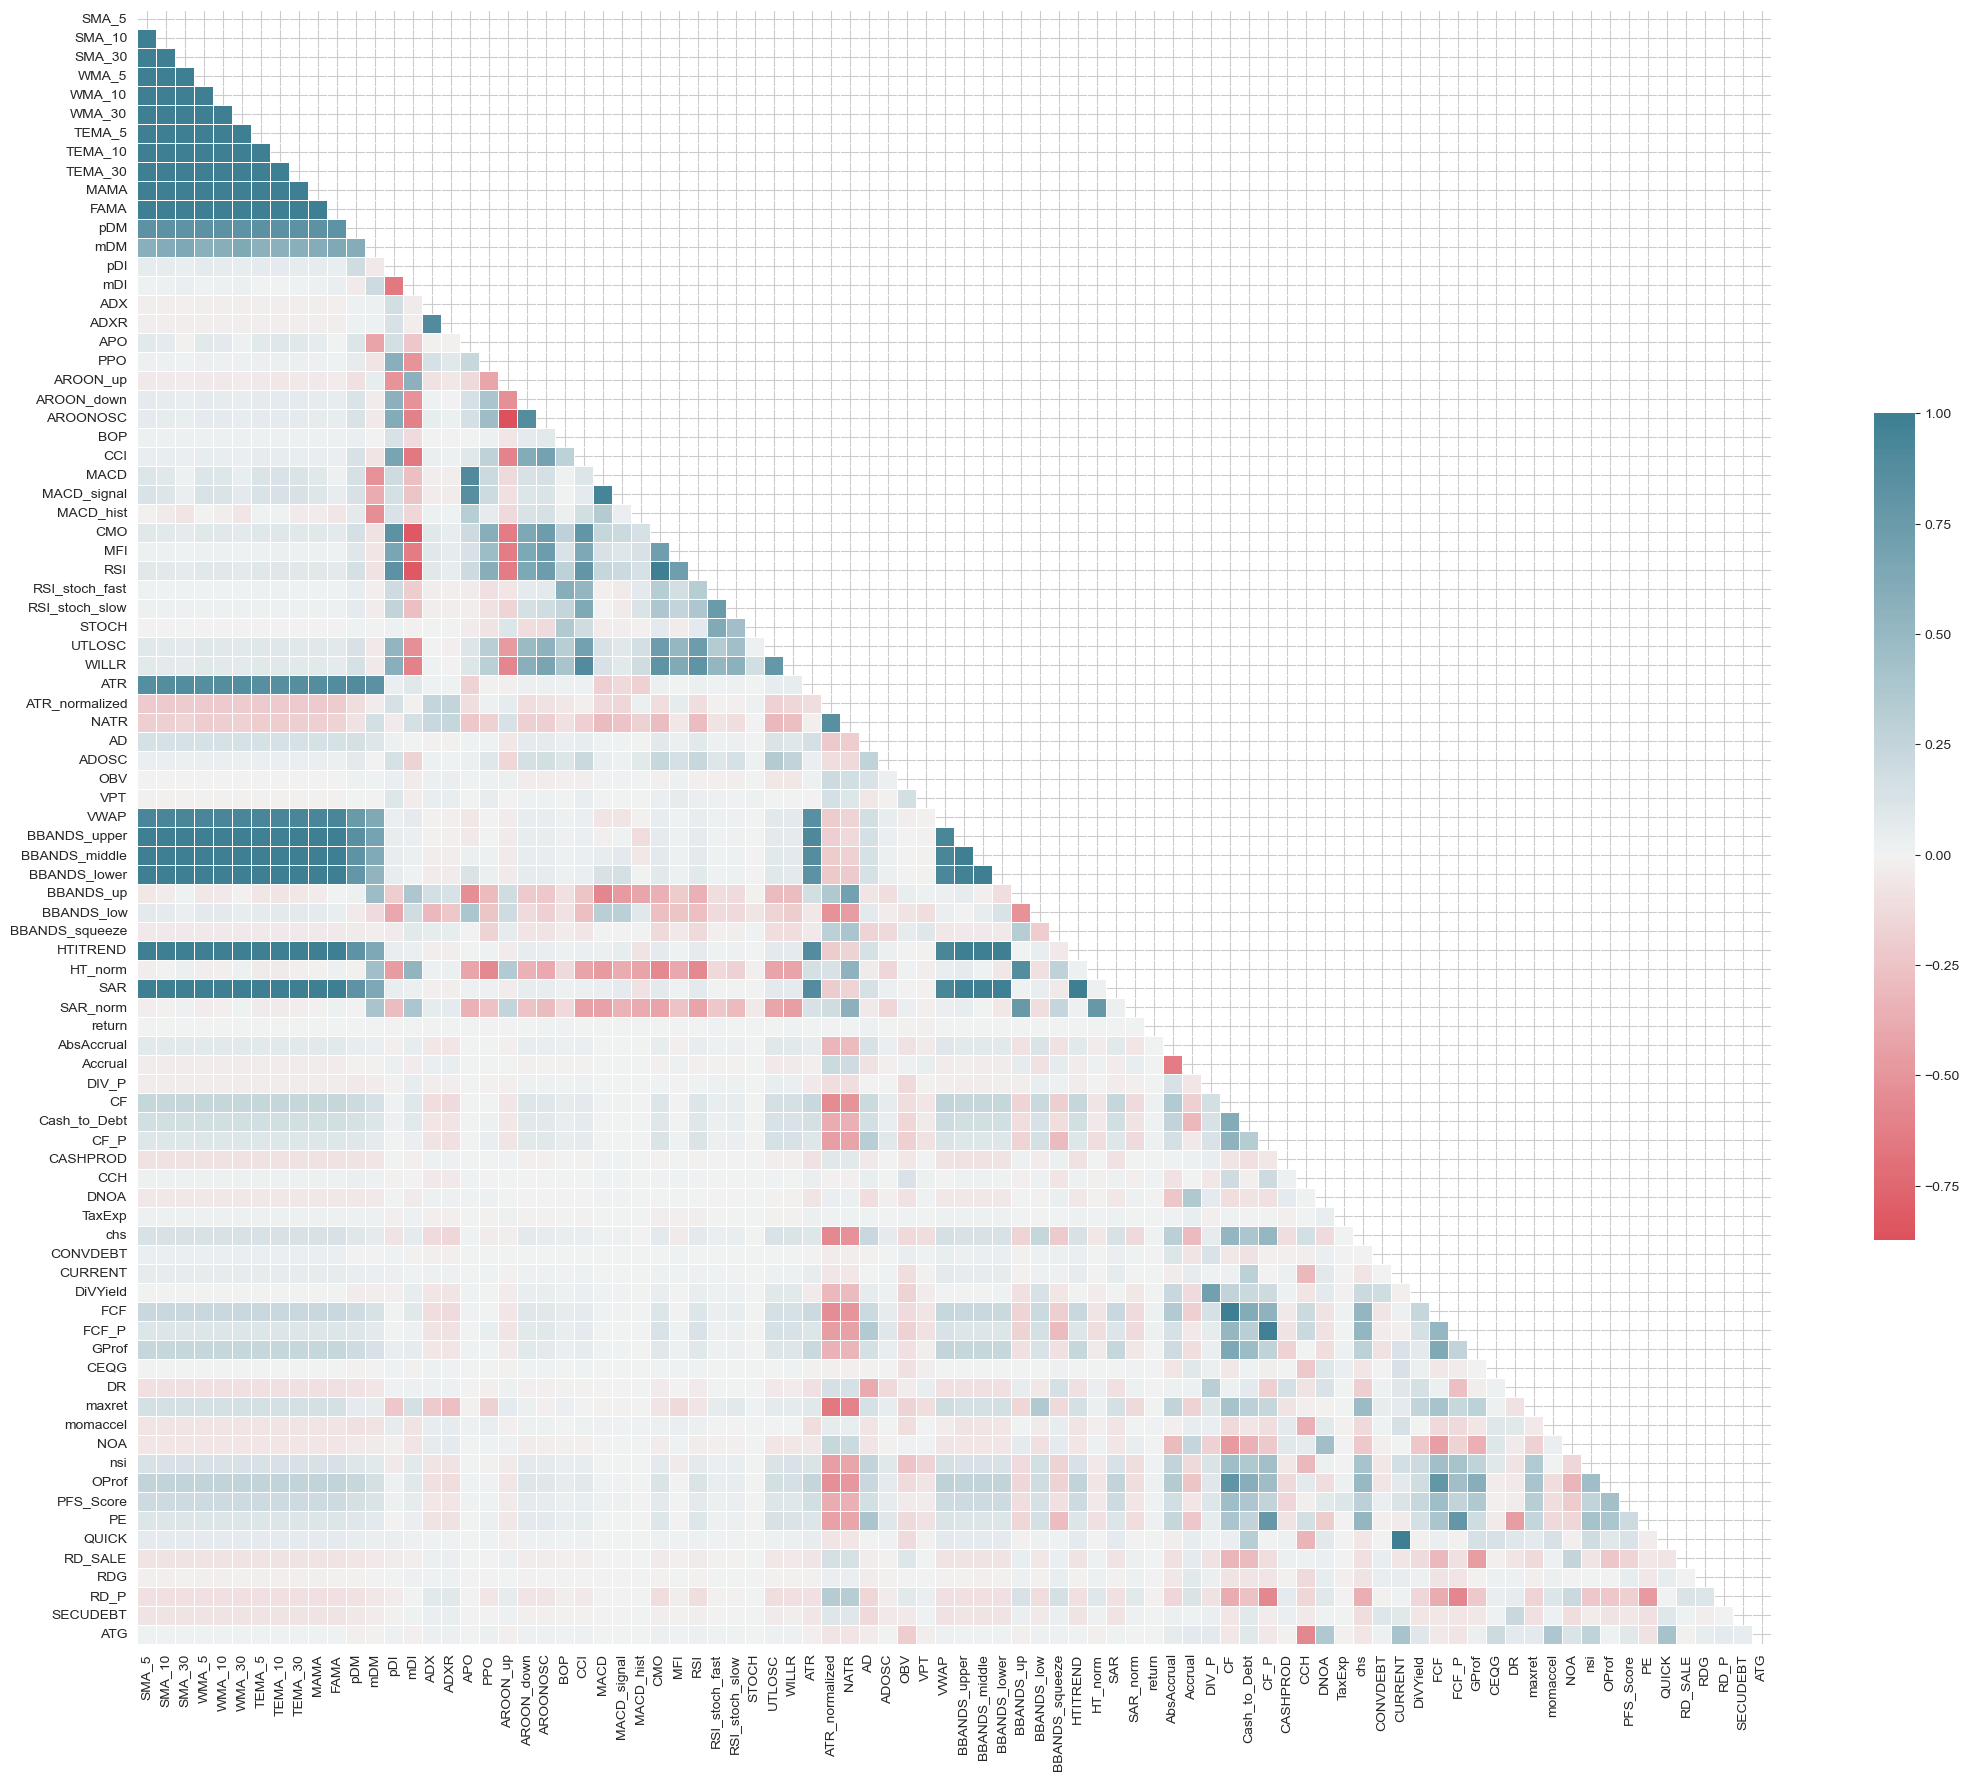

In [18]:
mask = np.triu(np.ones_like(corr_all, dtype= bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_all, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()
fig.savefig("figure storage/factor correlation", dpi=300);

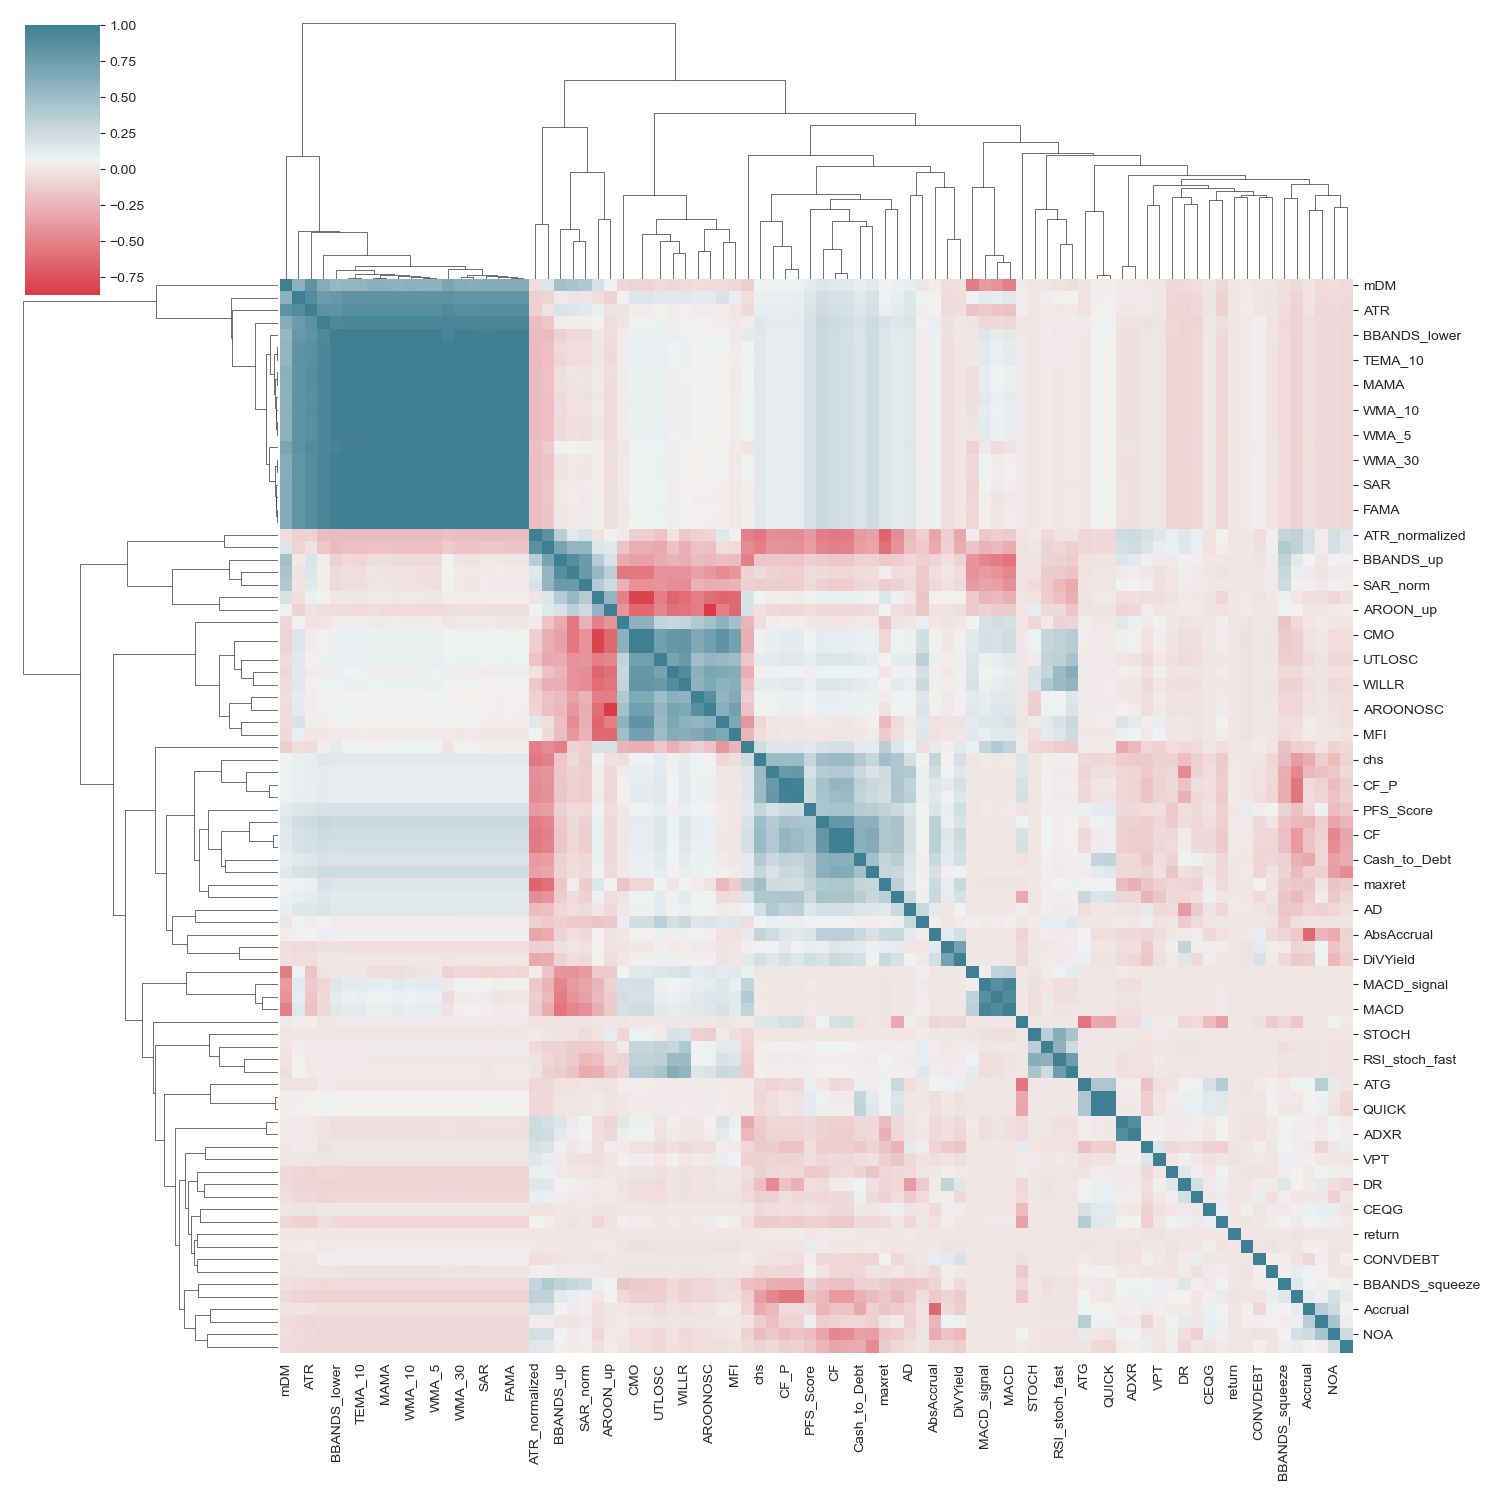

In [19]:
g = sns.clustermap(corr_all, cmap=cmap, figsize=(15, 15))
g.savefig('figure storage/factor_corr_cluster', dpi=300);

In [20]:
corr_ = corr_all.stack().reset_index()
corr_.columns = ['x1', 'x2', 'rho']
corr_ = corr_[corr_.x1!=corr_.x2].drop_duplicates('rho')

## Return correlation

In [21]:
corr_ret = df_factor.corrwith(df_all['alpha'], method='spearman')

In [22]:
corr_ret.dropna(inplace=True)

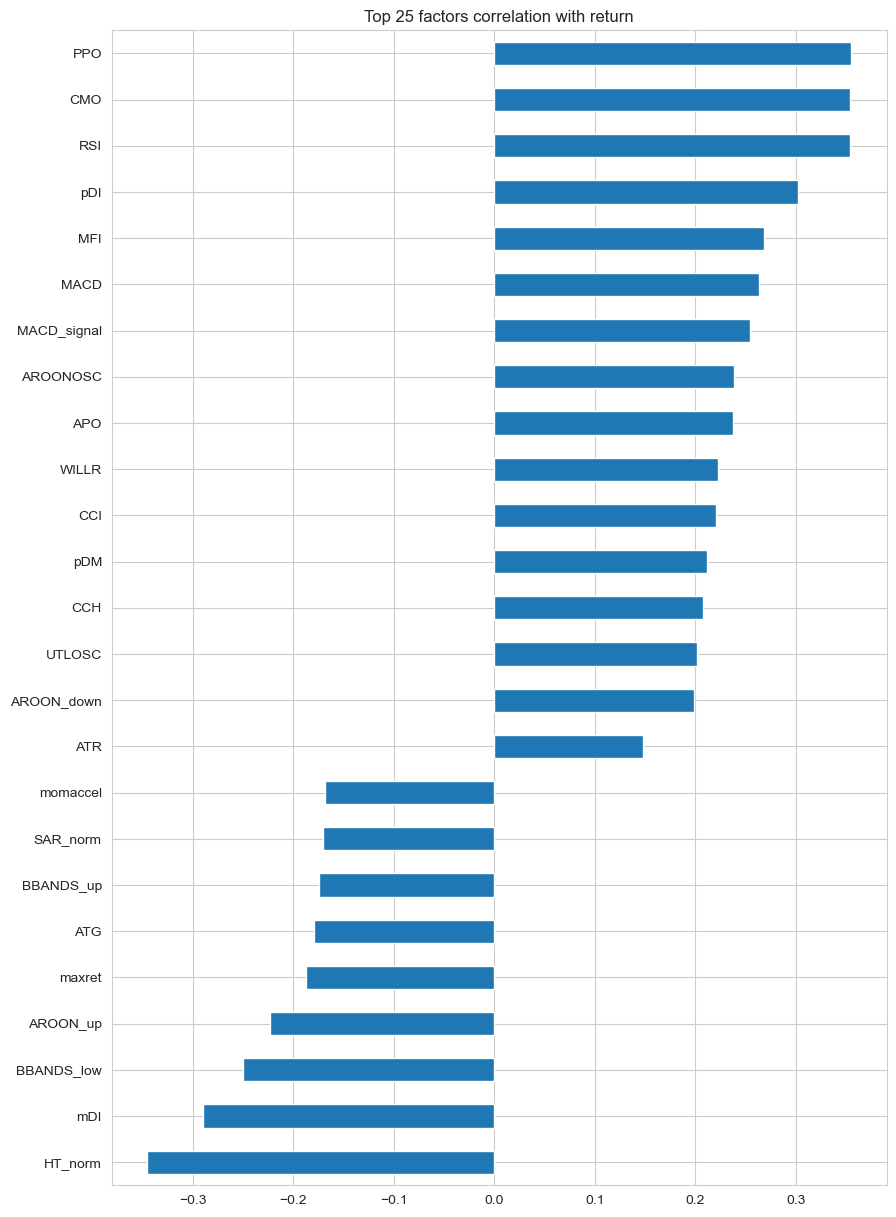

In [23]:
top25 = corr_ret.abs().nlargest(25).index
corr_ret.loc[top25].sort_values().plot.barh(figsize=(10, 15),
                                            legend=False);
plt.title('Top 25 factors correlation with return')
fig.savefig("figure storage/top 25 factors correlation with return", dpi=300);

# Mutual Information

In [24]:
mi = {}
features = df_factor.columns.tolist()
for feature in tqdm(features):
    discrete_features = df_factor[feature].nunique() < 10
    mi[feature] = mutual_info_regression(X=df_all[[feature]],
                                         y=df_all['alpha'],
                                         discrete_features=discrete_features)[0]
mi = pd.Series(mi)

100%|██████████| 86/86 [08:22<00:00,  5.85s/it]


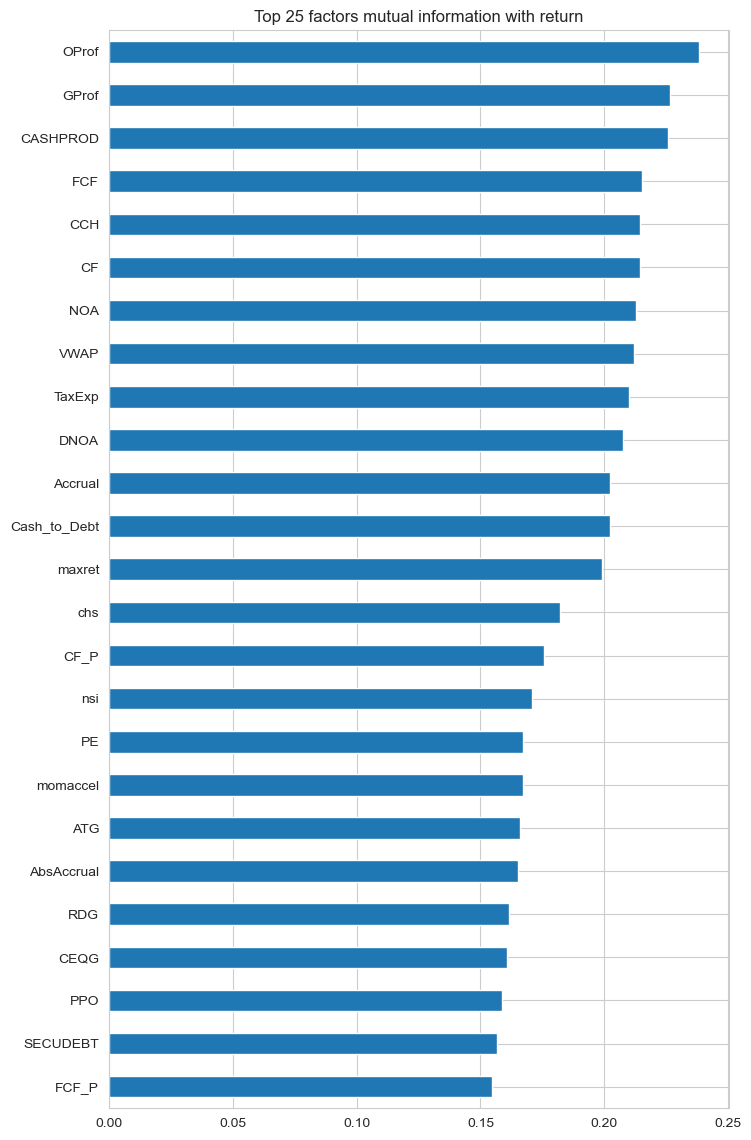

In [25]:
mi.nlargest(25).sort_values().plot.barh(figsize=(8, 14));
plt.title('Top 25 factors mutual information with return')
fig.savefig("figure storage/top 25 factors mutual information with return", dpi=300);

# SHAP Values

In [26]:
shap.initjs()
model = lgb.LGBMRegressor(learning_rate = 0.1, max_depth = 7, num_leaves = 70)
model.fit(df_factor, df_all['alpha'])
explainer = shap.TreeExplainer(model)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20963
[LightGBM] [Info] Number of data points in the train set: 296888, number of used features: 86
[LightGBM] [Info] Start training from score -0.642205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [27]:
shap_values = explainer.shap_values(df_factor)

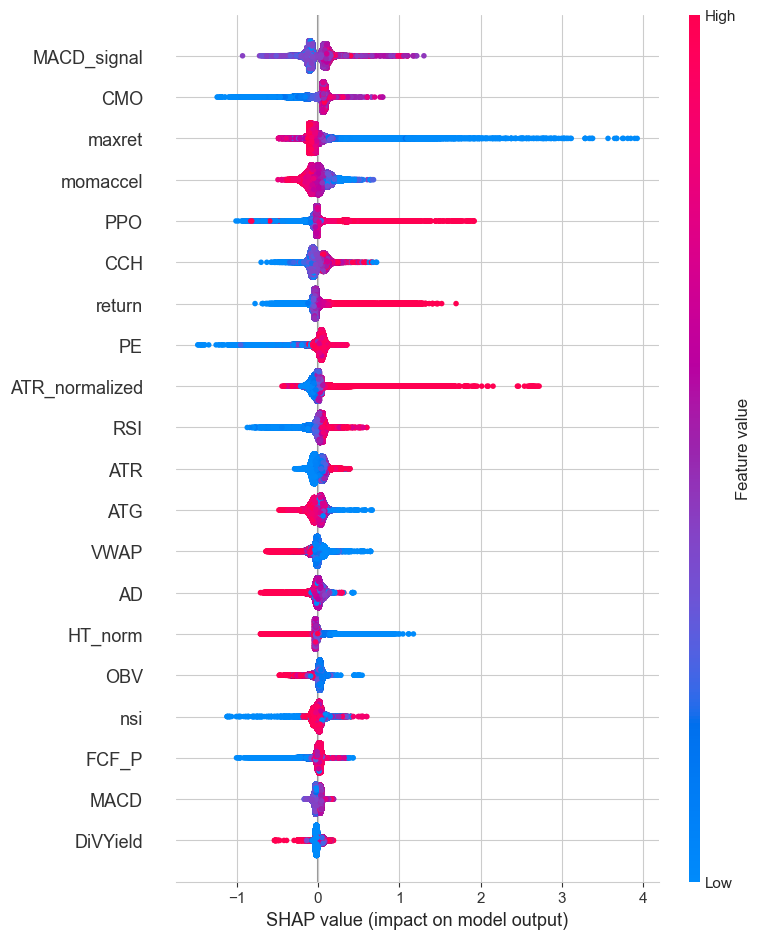

In [28]:
shap.summary_plot(shap_values,df_factor)
fig.savefig("figure storage/SHAP summary plot", dpi=300);

In [29]:
shap_values = pd.DataFrame(shap_values, columns = features)
shap_summary = shap_values.abs().mean()
shap_summary /= shap_summary.sum()

# Feature Metrics

In [30]:
stats = (mi.to_frame('Mutual Information')
         .join(corr_ret.to_frame('Information Coefficient'))
         .join(shap_summary.to_frame('SHAP Values')))

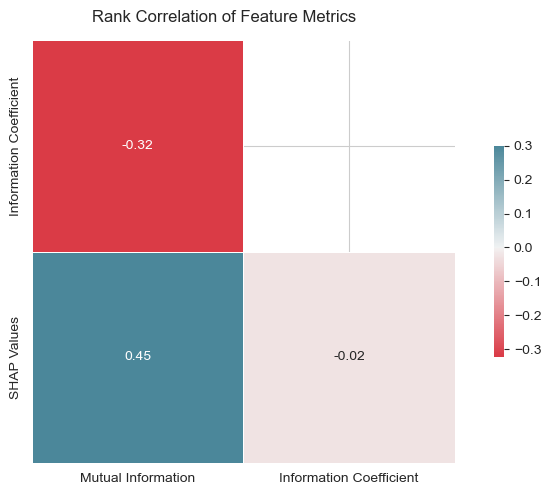

In [31]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}
corr = stats.assign(**cols).corr('spearman')
mask = np.triu(np.ones_like(corr, dtype= bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig('figure storage/metrics_correlation', dpi=300);